Load and merge the csv files containing the twitter data

In [2]:
import pandas as pd
import requests
from io import BytesIO
from typing import List

def load_and_merge_csv_xz_from_github(years: List[int], companies: List[str], base_url: str) -> pd.DataFrame:
    all_dataframes = []
    
    for year in years:
        for company in companies:
            filename = f"df_{year}_{company}.csv.xz"
            file_url = f"{base_url}/{filename}"
            
            response = requests.get(file_url)
            if response.status_code == 200:
                file_content = BytesIO(response.content)
                df = pd.read_csv(file_content, compression='xz')
                all_dataframes.append(df)

    merged_dataframe = pd.concat(all_dataframes, ignore_index=True)

    # Sort dataframe by date
    df_sorted = merged_dataframe.sort_values(by='post_date')

    # Remove the 'Unnamed: 0' column
    df_sorted = df_sorted.drop(columns=['Unnamed: 0'])
    
    # Drop 'year' columns that was used previously to split dataframes and save them as smaller csv files 
    df_sorted = df_sorted.drop(columns=['year'])


    # Reset the index of the dataframe and drop the old one
    df_sorted = df_sorted.reset_index(drop=True)

    return df_sorted

    
base_url = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data"
years = [2015, 2016, 2017, 2018, 2019]
companies = ['AAPL', 'AMZN', 'GOOGL', 'TSLA', 'GOOG', 'MSFT']
tweets_df = load_and_merge_csv_xz_from_github(years, companies, base_url)

# Optionally, you can display the first few rows of the merged DataFrame to verify it loaded correctly
# print(merged_df.head())


In [3]:
tweets_df

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,AAPL,apple,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0
2,AMZN,Amazon.com,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,TSLA,Tesla Inc,550443808606126081,aaplstocknews,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...,...,...
4336440,TSLA,Tesla Inc,1212159838882533376,ShortingIsFun,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...,0,0,1
4336441,TSLA,Tesla Inc,1212160015332728833,Commuternyc,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...,0,0,5
4336442,AAPL,apple,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1
4336443,MSFT,Microsoft,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1


In [4]:
tweets_df.columns

Index(['ticker_symbol', 'company_name', 'tweet_id', 'writer', 'post_date',
       'body', 'comment_num', 'retweet_num', 'like_num'],
      dtype='object')

In [5]:
import pandas as pd
import re

def filter_tweets_v7(df):
    df = df.copy()

    print("Initial dataset length:", len(df))

    # Normalize URLs in the tweet bodies - replace with "URL" or remove
    df['body'] = df['body'].apply(lambda text: re.sub(r'http\S+', 'URL', text))

    # Remove all duplicates based on 'tweet_id' and 'ticker_symbol' (seen as spam)
    df.drop_duplicates(subset=['tweet_id', 'ticker_symbol'], inplace=True, keep = False)
    print("After removing duplicate tweet_ids and ticker_symbols:", len(df))

    # Remove last duplicates based on 'tweet_id' and 'company_name'(will only apply to Google as they have different ticker_symbols)
    df.drop_duplicates(subset=['tweet_id', 'company_name'], inplace=True, keep = 'first')
    print("After removing duplicate tweet_ids and company_names (Google):", len(df))

    # Remove tweets with duplicate texts longer than 5 words considering the ticker symbol
    df['word_count'] = df['body'].apply(lambda text: len(text.split()))
    duplicates = df[(df['word_count'] > 5)].duplicated(subset=['body', 'ticker_symbol'], keep=False)
    df = df.loc[~df.index.isin(duplicates[duplicates].index)]
    print("After removing long duplicate texts:", len(df))

    # Apply counting functions
    df['hashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('#')))
    df['cashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('$')))
    df['mention_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('@')))

    # Filter tweets based on hashtag and cashtag counts
    df = df[(df['cashtag_count'] < 5) & (df['hashtag_count'] < 8)]
    print("After filtering by cashtags and hashtags:", len(df))

    # Ratio filters (cashtags, hashtags, mentions to words)
    df['cashtag_ratio'] = df['cashtag_count'] / df['word_count'].replace(0, 1)
    df['hashtag_ratio'] = df['hashtag_count'] / df['word_count'].replace(0, 1)
    df['mention_ratio'] = df['mention_count'] / df['word_count'].replace(0, 1)
    df = df[(df['cashtag_ratio'] <= 0.5) & (df['hashtag_ratio'] <= 0.5) & (df['mention_ratio'] <= 0.5)]
    print("After filtering by ratios:", len(df))

    # Keyword filter (defined by Wilksch, Abramova (2023) PyFin-sentiment: Towards a machine-learning-based model for deriving sentiment from financial tweets)
    keywords = ['bitcoin', 'etherium', 'btc', 'eth', 'nft', 'token', 'wallet', 'web3',
                'airdrop', 'wagmi', 'solana', 'opensea', 'cryptopunks', 'uniswap', 
                'lunar', 'hodl', 'binance', 'coinbase', 'cryptocom', 'doge']
    df['keyword_count'] = df['body'].apply(lambda text: sum(text.lower().count(kw) for kw in keywords))
    df = df[df['keyword_count'] <= 2]
    print("After filtering by keyword count:", len(df))

    return df




In [6]:
filtered_df_7 = filter_tweets_v7(tweets_df)


Initial dataset length: 4336445
After removing duplicate tweet_ids and ticker_symbols: 4336445
After removing duplicate tweet_ids and company_names (Google): 4288706
After removing long duplicate texts: 3196398
After filtering by cashtags and hashtags: 2529106
After filtering by ratios: 2508943
After filtering by keyword count: 2508222


In [7]:
# filtered_df_7[filtered_df_7['ticker_symbol'].isin(['GOOG', 'GOOGL'])].head(n=50)


In [8]:
import pandas as pd

def check_empty_bodies(df):
    # Check for empty or NaN entries in the 'body' column
    empty_bodies = df['body'].isna() | (df['body'] == '')
    
    # Count the number of empty or NaN entries
    empty_count = empty_bodies.sum()
    
    # Print the results
    if empty_count > 0:
        print(f"There are {empty_count} empty 'body' cells in the DataFrame.")
    else:
        print("There are no empty 'body' cells in the DataFrame.")

    # Optionally, you might want to return a DataFrame with the empty entries for review
    empty_entries = df[empty_bodies]
    return empty_entries


In [9]:
# Check processed data frame for missing text values
empty_entries = check_empty_bodies(filtered_df_7)
if not empty_entries.empty:
    print("Empty entries found:", empty_entries)

There are no empty 'body' cells in the DataFrame.


In [10]:
# limit magnitude of preparation as it doesn't seem to be necessary according to example in pyfin documentation
import re

def preprocess_text_column(df):
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    def transform_text(text):
        # Replace cashtags with 'TICKER'
        # text = re.sub(r'\$\w+', 'TICKER', text)
        
        # Replace mentions with '@user'
        text = re.sub(r'@\w+', '@user', text)
        
        # Replace all digits with '9'
        # text = re.sub(r'\d', '9', text)
        
        # Replace newlines with spaces
        text = text.replace('\n', ' ')
        
        # Convert to lowercase
        text = text.lower()

        # Remove repeated characters more than twice
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        
        return text

    # Apply the transformation to the 'body' column
    df['body'] = df['body'].apply(transform_text)
    
    return df

# # To test the function, you would use:
# df = pd.DataFrame({'body': ['Helloooo!!!! How are youuuu???']})
# print(preprocess_text_column(df))

In [11]:
# Preprocess text column
preprocessed_df = preprocess_text_column(filtered_df_7)


In [12]:
# Filtering and preprocessing example
print(tweets_df["body"][3])
print(filtered_df_7["body"][3])
print(preprocessed_df["body"][3])


$GM $TSLA: Volkswagen Pushes 2014 Record Recall Tally Higher https://pic.twitter.com/WIIc1lW7hW @ProTradersNews http://growword.com/2015/01/01/0246.html… @theferrarifan
$GM $TSLA: Volkswagen Pushes 2014 Record Recall Tally Higher URL @ProTradersNews URL @theferrarifan
$gm $tsla: volkswagen pushes 2014 record recall tally higher url @user url @user


Use pyFIN to obtain sentiment scores. For now, it's commented out bc only Inga can run it without warning. We import the sentiment_df resulting from the code below.

In [13]:
# %pip install pyfin-sentiment


In [14]:
# align the scikit-learn version to pyfin to not get warnings

# FAILED. First try without version alignment

# %pip install scikit-learn==1.1.1


In [15]:
# WARNINGS CAN BE IGNORED (PROOF THROUGH COMPARING SENTIMENT LABELS OBTAINED BY 1.1.1 AND 1.3.0)
from pyfin_sentiment.model import SentimentModel
import numpy as np

# Initialize the sentiment model
# SentimentModel.download("small")  # This line is commented because it's assumed the model is already downloaded
model = SentimentModel("small")

def apply_batch_sentiment(texts, batch_size=1000):
    # Initialize an empty list to store sentiment results
    sentiments = []
    
    # Process texts in batches
    total_texts = len(texts)
    for i in range(0, total_texts, batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_predictions = model.predict(batch_texts)
        sentiments.extend(batch_predictions)
        
        # Print progress
        processed = min(i + batch_size, total_texts)
        print(f"Processed {processed}/{total_texts} texts")
    
    return sentiments

# Assume preprocessed_df is your DataFrame and has already been defined
# Apply sentiment analysis in batches to the 'body' column and store the results in a new column
preprocessed_df['sentiment'] = apply_batch_sentiment(preprocessed_df['body'].tolist(), batch_size=1000)

# Now the DataFrame preprocessed_df includes a new column 'sentiment' with sentiment labels


/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/friederikeeichholz/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression

Processed 1000/2508222 texts
Processed 2000/2508222 texts
Processed 3000/2508222 texts
Processed 4000/2508222 texts
Processed 5000/2508222 texts
Processed 6000/2508222 texts
Processed 7000/2508222 texts
Processed 8000/2508222 texts
Processed 9000/2508222 texts
Processed 10000/2508222 texts
Processed 11000/2508222 texts
Processed 12000/2508222 texts
Processed 13000/2508222 texts
Processed 14000/2508222 texts
Processed 15000/2508222 texts
Processed 16000/2508222 texts
Processed 17000/2508222 texts
Processed 18000/2508222 texts
Processed 19000/2508222 texts
Processed 20000/2508222 texts
Processed 21000/2508222 texts
Processed 22000/2508222 texts
Processed 23000/2508222 texts
Processed 24000/2508222 texts
Processed 25000/2508222 texts
Processed 26000/2508222 texts
Processed 27000/2508222 texts
Processed 28000/2508222 texts
Processed 29000/2508222 texts
Processed 30000/2508222 texts
Processed 31000/2508222 texts
Processed 32000/2508222 texts
Processed 33000/2508222 texts
Processed 34000/250

In [57]:
preprocessed_df.head(n=2)

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,sentiment
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,-1
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,1


In [58]:
# Replace sentiment values so we can compute their average

# Convert the 'sentiment' column to integer
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].astype(int)

# Define the mapping of old values to new values
replacement_map = {2: 0, 3: -1}

# Replace the values in the 'sentiment' column
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace(replacement_map)

preprocessed_df.head(n=2)

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,sentiment
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,-1
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,1


In [64]:
# Add weighted interactions columns (likes: 1.5, comments: 2, retweets: 3)
# Add +1 so the weights don't become 0 (would lead to sparse dataset as most tweets actually have zero interaction) 
preprocessed_df['weighted_interactions'] = 1.5*preprocessed_df['like_num'] + 2*preprocessed_df['comment_num'] + 3*preprocessed_df['retweet_num'] + 1

In [70]:
# maximum weighted interaction
print(preprocessed_df['weighted_interactions'].max())

# minimum weighted interaction
print(preprocessed_df['weighted_interactions'].min())


3760.0
1.0


In [74]:
preprocessed_df[preprocessed_df['weighted_interactions'] == 3760.0]


,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,sentiment,weighted_interactions
164878,AAPL,apple,575014851363405824,RANsquawk,2015-03-09 19:26:38,loving my apple watch $aapl,66,882,654,5,0,1,0,0.2,0.0,0.0,0,0,3760.0


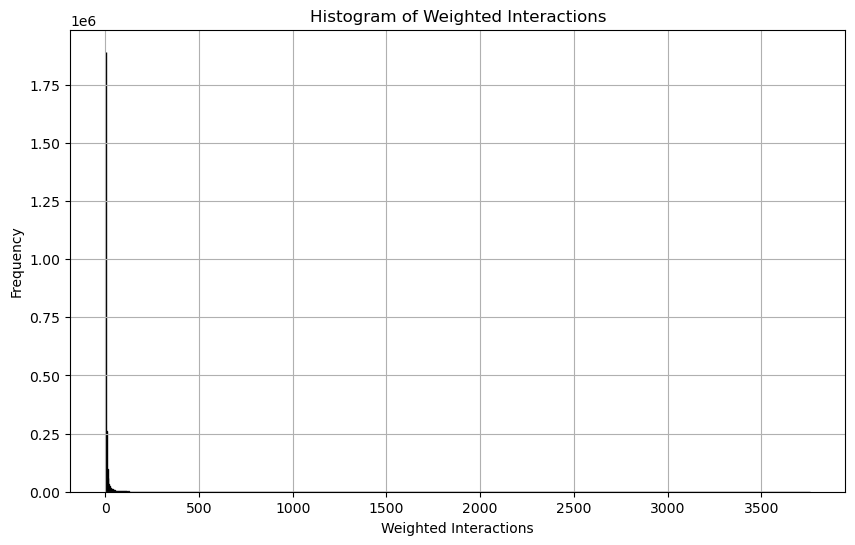

In [73]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(preprocessed_df['weighted_interactions'], bins=1000, color='blue', edgecolor='black')
plt.title('Histogram of Weighted Interactions')
plt.xlabel('Weighted Interactions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [67]:
# Check if every writer published more than one tweet

tweets_per_writer = preprocessed_df.groupby('writer')['tweet_id'].count()

print(tweets_per_writer)


writer
0000derek          9
00012859dn         1
0001_Trader       17
001DanDan          1
003bitcoin         1
                  ..
zzggim             1
zzmultimediaes     1
zzrawlins          1
zzumot             1
zzz_ebooks         7
Name: tweet_id, Length: 95795, dtype: int64


To not introduce bias, the first version of the sentiment index is not weighted in respect to likes comments etc. but only based on the market cap of the companies

In [87]:
# Convert post_date to datetime object and add column that only contains date (not time)

# type(preprocessed_df['post_date'])

preprocessed_df['post_date'] = pd.to_datetime(preprocessed_df['post_date'])

preprocessed_df['date_only'] = preprocessed_df['post_date'].dt.date
preprocessed_df['weekday'] = preprocessed_df['post_date'].dt.day_of_week



In [88]:
preprocessed_df

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,...,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,sentiment,weighted_interactions,date_only,weekday
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,20,...,1,0,0.050000,0.000000,0.000000,0,-1,1.0,2015-01-01,3
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,13,...,2,2,0.153846,0.000000,0.153846,0,1,2.5,2015-01-01,3
20,AAPL,apple,550444969924653056,AppleNewsAAPL,2015-01-01 00:14:42,$aapl apple goes global with 'start something ...,0,0,1,12,...,1,1,0.083333,0.000000,0.083333,1,0,2.5,2015-01-01,3
21,AAPL,apple,550444970738335744,espositooooo,2015-01-01 00:14:42,“@user: apple is being sued for falsely advert...,0,0,0,15,...,1,0,0.066667,0.000000,0.000000,0,0,1.0,2015-01-01,3
22,AAPL,apple,550445066444369921,Bidnessetc,2015-01-01 00:15:05,apple filed for its own stylus patent in 2010 ...,0,0,0,11,...,1,0,0.090909,0.000000,0.000000,0,1,1.0,2015-01-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336438,AAPL,apple,1212159275637886976,GMGRIFF_79,2019-12-31 23:51:06,"$aapl yearly~ heck of a year.. jan. 2, 19~arou...",0,0,1,28,...,1,0,0.035714,0.000000,0.000000,0,1,2.5,2019-12-31,1
4336441,TSLA,Tesla Inc,1212160015332728833,Commuternyc,2019-12-31 23:54:03,patiently waiting for the no twitter sitter tw...,0,0,5,10,...,2,0,0.200000,0.000000,0.000000,0,0,8.5,2019-12-31,1
4336442,AAPL,apple,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,i don't discriminate. i own both $aapl and $ms...,1,0,1,9,...,2,0,0.222222,0.000000,0.000000,0,0,4.5,2019-12-31,1
4336443,MSFT,Microsoft,1212160410692046849,MoriaCrypto,2019-12-31 23:55:37,i don't discriminate. i own both $aapl and $ms...,1,0,1,9,...,2,0,0.222222,0.000000,0.000000,0,0,4.5,2019-12-31,1


In [98]:
# Create new data frame grouped by date and company

# Group by 'company_name' and 'post_date', then calculate the average sentiment
grouped_df = preprocessed_df.groupby(['date_only', 'weekday', 'company_name'])['sentiment'].mean().reset_index()

# Rename the column for clarity
grouped_df.rename(columns={'sentiment': 'average_sentiment'}, inplace=True)
grouped_df.rename(columns={'date_only': 'date'}, inplace=True)
grouped_df['date'] = pd.to_datetime(grouped_df['date'])



In [102]:
grouped_df

,date,weekday,company_name,average_sentiment
0,2015-01-01,3,Amazon.com,-0.216667
1,2015-01-01,3,Google Inc,0.190476
2,2015-01-01,3,Microsoft,0.111111
3,2015-01-01,3,Tesla Inc,0.183673
4,2015-01-01,3,apple,0.289157
...,...,...,...,...
9118,2019-12-31,1,Amazon.com,0.335878
9119,2019-12-31,1,Google Inc,0.104167
9120,2019-12-31,1,Microsoft,0.406977
9121,2019-12-31,1,Tesla Inc,0.255466


In [162]:
# Load market cap file

market_cap_path = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/market_cap/total_market_cap_2015-2019.xlsx"

market_cap_df = pd.read_excel(market_cap_path).sort_values("date")

market_cap_df['date'] = pd.to_datetime(market_cap_df['date'])

market_cap_df['weights_abs'] = market_cap_df['weights_abs'].astype(int)

market_cap_df['weights_rel'] = market_cap_df.groupby('date')['weights_abs'].transform(lambda x: x / x.sum())

# replace company ticker by company name for a smooth join

replacements = {"AAPL.O": "apple", "AMZN.O": "Amazon.com", "GOOG.O": "Google Inc", "MSFT.O": "Microsoft", "TSLA.O": "Tesla Inc"}

market_cap_df['company_ticker'] = market_cap_df['company_ticker'].replace(replacements)

market_cap_df.rename(columns={'company_ticker': 'company_name'}, inplace=True)



In [163]:
market_cap_df.head(n=20)

,company_name,date,weekday,market_cap,weights_abs,weights_rel
0,apple,2015-01-02,4,6.412030e+11,697510000000,0.422972
5032,Tesla Inc,2015-01-02,4,2.749748e+10,30660000000,0.018592
2516,Google Inc,2015-01-02,4,3.576201e+11,370020000000,0.224381
3774,Microsoft,2015-01-02,4,3.854358e+11,394090000000,0.238977
1258,Amazon.com,2015-01-02,4,1.434618e+11,156790000000,0.095078
2517,Google Inc,2015-01-05,0,3.504869e+11,370020000000,0.224381
1259,Amazon.com,2015-01-05,0,1.405184e+11,156790000000,0.095078
5033,Tesla Inc,2015-01-05,0,2.634146e+10,30660000000,0.018592
1,apple,2015-01-05,0,6.231392e+11,697510000000,0.422972
3775,Microsoft,2015-01-05,0,3.818502e+11,394090000000,0.238977


In [164]:
# join market_cap_df and grouped_df by date

sentiment_df = pd.merge(market_cap_df, grouped_df, on=['date', 'weekday', 'company_name'])



In [166]:
sentiment_df.head(n=20)

,company_name,date,weekday,market_cap,weights_abs,weights_rel,average_sentiment
0,apple,2015-01-02,4,6.412030e+11,697510000000,0.422972,0.223438
1,Tesla Inc,2015-01-02,4,2.749748e+10,30660000000,0.018592,0.045802
2,Google Inc,2015-01-02,4,3.576201e+11,370020000000,0.224381,0.123967
3,Microsoft,2015-01-02,4,3.854358e+11,394090000000,0.238977,0.208333
4,Amazon.com,2015-01-02,4,1.434618e+11,156790000000,0.095078,0.183673
5,Google Inc,2015-01-05,0,3.504869e+11,370020000000,0.224381,0.156028
6,Amazon.com,2015-01-05,0,1.405184e+11,156790000000,0.095078,0.150685
7,Tesla Inc,2015-01-05,0,2.634146e+10,30660000000,0.018592,0.107914
8,apple,2015-01-05,0,6.231392e+11,697510000000,0.422972,0.213139
9,Microsoft,2015-01-05,0,3.818502e+11,394090000000,0.238977,0.254902


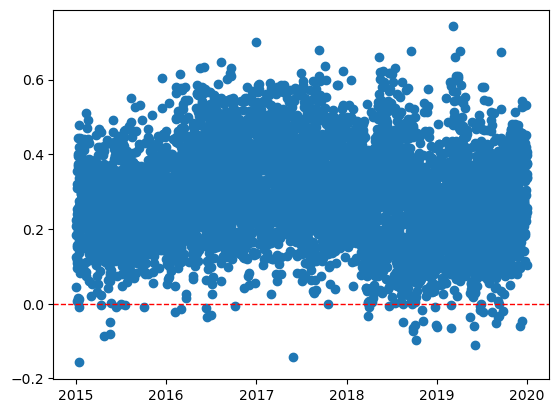

In [181]:
plt.scatter(sentiment_df['date'], sentiment_df['average_sentiment'])
plt.axhline(0, color='red', linewidth=1, linestyle='--')

In [188]:
# Compute unweighted sentiment index
sentiment_index_unweighted_df = sentiment_df.groupby('date')['average_sentiment'].mean().reset_index()
sentiment_index_unweighted_df.columns = ['date', 'average_daily_sentiment']


In [189]:
sentiment_index_unweighted_df

,date,average_daily_sentiment
0,2015-01-02,0.157043
1,2015-01-05,0.176534
2,2015-01-06,0.175732
3,2015-01-07,0.221803
4,2015-01-08,0.279241
...,...,...
1253,2019-12-24,0.296715
1254,2019-12-26,0.397847
1255,2019-12-27,0.328775
1256,2019-12-30,0.341521


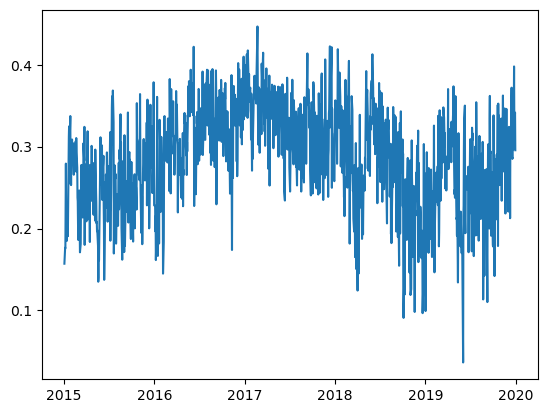

In [191]:
plt.plot(sentiment_index_unweighted_df["date"], sentiment_index_unweighted_df["average_daily_sentiment"])

In [168]:
# Calculate the weighted average of sentiment per day
sentiment_index_df = sentiment_df.groupby('date').apply(
    lambda x: pd.Series({
        'weighted_sentiment': (x['weights_rel'] * x['average_sentiment']).sum()
    })
).reset_index()

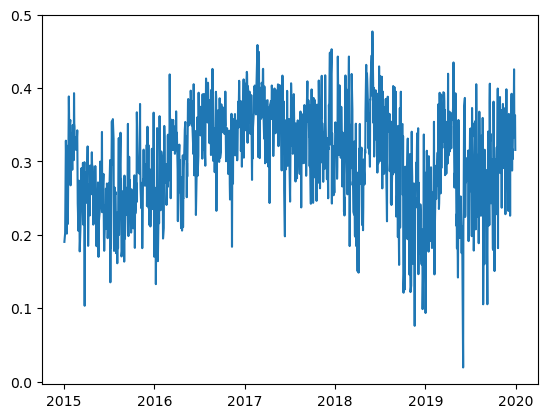

In [173]:
plt.plot(sentiment_index_df["date"], sentiment_index_df["weighted_sentiment"])

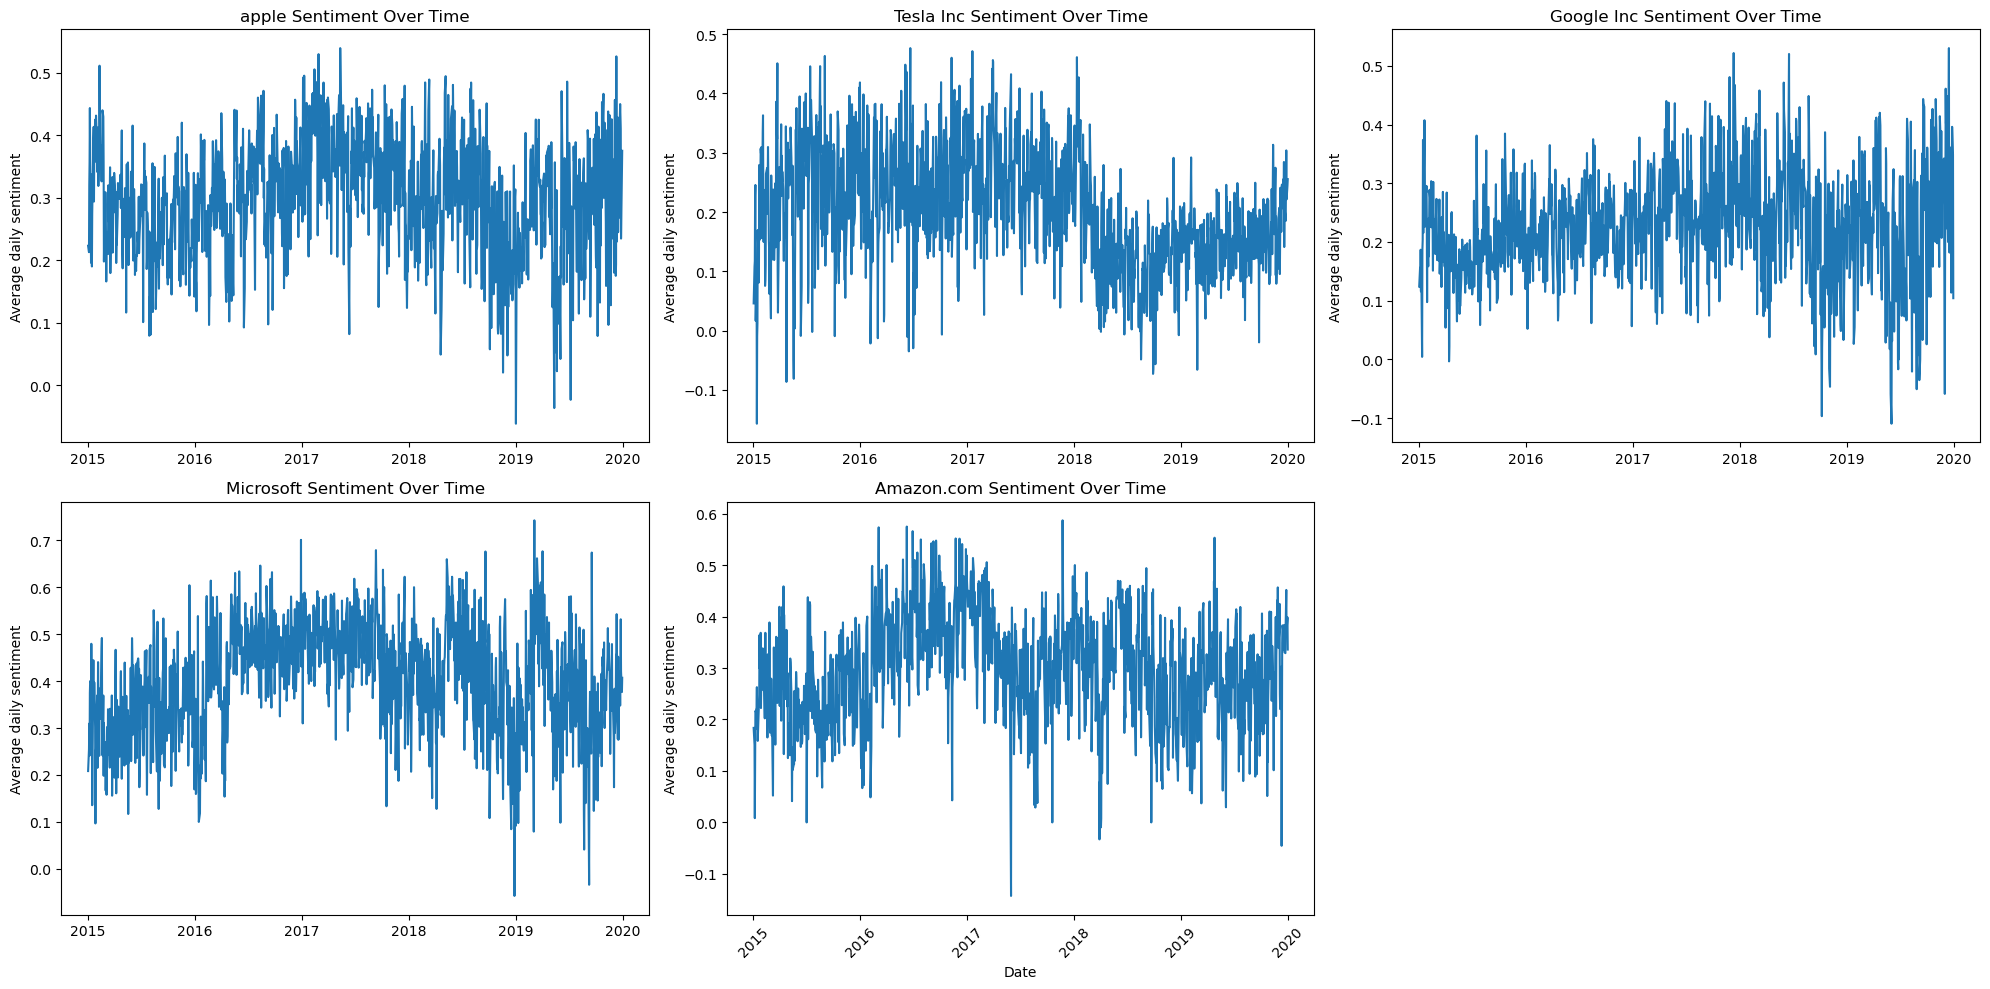

In [176]:
#Get unique list of companies
companies = sentiment_df['company_name'].unique()

# Set up the matplotlib figure and axes
#fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

plt.figure(figsize=(20,10))
# Plot each company's data on a separate subplot
for i, company in enumerate(companies):
    # Filter the DataFrame for the current company
    data = sentiment_df[sentiment_df['company_name'] == company]
    
    # Plot on ith subplot
    plt.subplot(2,3,i+1)
    plt.plot(data['date'], data['average_sentiment'], label=f'{company} Sentiment')
    plt.title(f'{company} Sentiment Over Time')
    plt.ylabel('Average daily sentiment')
    
# Set common labels
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [167]:
import pandas as pd

# Sample DataFrame setup
data = {
    'company_name': ['Company A', 'Company B', 'Company C', 'Company A', 'Company B', 'Company C'],
    'date': pd.to_datetime(['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-02', '2021-01-02', '2021-01-02']),
    'weekday': ['Friday', 'Friday', 'Friday', 'Saturday', 'Saturday', 'Saturday'],
    'market_cap': [100, 150, 200, 120, 180, 220],
    'weights_abs': [0.2, 0.3, 0.5, 0.25, 0.35, 0.4],
    'weights_rel': [0.2, 0.3, 0.5, 0.25, 0.35, 0.4],
    'average_sentiment': [0.5, 0.6, 0.4, 0.7, 0.65, 0.5]
}
df = pd.DataFrame(data)

# Calculate the weighted average of sentiment per day
sentiment_index_df = df.groupby('date').apply(
    lambda x: pd.Series({
        'weighted_sentiment': (x['weights_rel'] * x['average_sentiment']).sum()
    })
).reset_index()

# Display the result
print(sentiment_index_df)


        date  weighted_sentiment
0 2021-01-01              0.4800
1 2021-01-02              0.6025


In [148]:
697510000000/1649070000000

0.422971735584299

In [140]:
print(market_cap_df['weights_abs'].unique())


[697510000000 156790000000 370020000000 394090000000 30660000000
 359735987202.85 25572614868.9 381497780636.3 748247128080 176540198250.24
 368116903511.65 379077497480.22 750546988400 199884237173.11
 31702071284.4 32326962121.86 348072131770.88 643038932720 239883893710.02
 433933468262.14 659561657300 311632980924 517634684932.15 434143079811.2
 30152850712.94 25345572952.34 402425325141.12 486955963844.39
 536105730270 260149641178.199 416604743368 32565085277.76
 341032531208.399 546975660500 509617523299.3 571713802300 364638405564.72
 535009034077.25 447757944824.58 31524319186.05 30510199590.6 589327232760
 356645740170.39 528610017489 468542621190.26 494407357883.6
 576666389221.63 40415990295.72 718723514600 403228259034.72
 56014212573.36 539200748813.04 675105049679.97 796466198400
 475403990815.38 847097392000 471060154370.2 656333759713.8
 575896782309.83 59395091485.6999 882331517200 567043081931.25
 714774791100.87 649337056713.15 51907614945.75 903783195560
 732187908

In [ ]:
market_cap_df['weights_abs']


0               697510000000
1               156790000000
2               370020000000
3               394090000000
4                30660000000
                ...         
6288    1154848594452.830078
6285           1187462571250
6286            892831633776
6287     899713394424.949951
6289      59469988448.519997
Name: weights_abs, Length: 6290, dtype: object

In [136]:
market_cap_df['weights_abs']


0               697510000000
1               156790000000
2               370020000000
3               394090000000
4                30660000000
                ...         
6288    1154848594452.830078
6285           1187462571250
6286            892831633776
6287     899713394424.949951
6289      59469988448.519997
Name: weights_abs, Length: 6290, dtype: object

In [128]:
market_cap_df["weights_abs"].dtype

dtype('O')

In [125]:
market_cap_df

,company_ticker,date,weekday,market_cap,weights_abs
0,AAPL.O,2015-01-02,4,6.412030e+11,697510000000
1,AMZN.O,2015-01-02,4,1.434618e+11,156790000000
2,GOOG.O,2015-01-02,4,3.576201e+11,370020000000
3,MSFT.O,2015-01-02,4,3.854358e+11,394090000000
4,TSLA.O,2015-01-02,4,2.749748e+10,30660000000
...,...,...,...,...,...
6288,MSFT.O,2019-12-31,1,1.203063e+12,1154848594452.830078
6285,AAPL.O,2019-12-31,1,1.304765e+12,1187462571250
6286,AMZN.O,2019-12-31,1,9.161539e+11,892831633776
6287,GOOG.O,2019-12-31,1,9.229463e+11,899713394424.949951


In [118]:
import pandas as pd

# Sample DataFrame
data = {
    'company_ticker': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C'],
    'date': ['2021-01-01', '2021-01-01', '2021-01-01', '2021-01-02', '2021-01-02', '2021-01-02',
             '2021-01-03', '2021-01-03', '2021-01-03', '2021-01-04', '2021-01-04', '2021-01-04',
             '2021-01-05', '2021-01-05', '2021-01-05'],
    'weekday': ['Friday', 'Friday', 'Friday', 'Saturday', 'Saturday', 'Saturday',
                'Sunday', 'Sunday', 'Sunday', 'Monday', 'Monday', 'Monday',
                'Tuesday', 'Tuesday', 'Tuesday'],
    'market_cap': [100, 150, 200, 120, 180, 220, 130, 170, 230, 140, 160, 240, 150, 190, 210],
    'weights_abs': [1, 3, 5, 0.25, 0.35, 0.4, 0.22, 0.33, 0.45, 0.28, 0.32, 0.4, 0.24, 0.36, 0.4]
}
df = pd.DataFrame(data)

# Calculating relative weights
df['weights_rel'] = df.groupby('date')['weights_abs'].transform(lambda x: x / x.sum())

# Displaying the updated DataFrame
print(df)


   company_ticker        date   weekday  market_cap  weights_abs  weights_rel
0               A  2021-01-01    Friday         100         1.00     0.111111
1               B  2021-01-01    Friday         150         3.00     0.333333
2               C  2021-01-01    Friday         200         5.00     0.555556
3               A  2021-01-02  Saturday         120         0.25     0.250000
4               B  2021-01-02  Saturday         180         0.35     0.350000
5               C  2021-01-02  Saturday         220         0.40     0.400000
6               A  2021-01-03    Sunday         130         0.22     0.220000
7               B  2021-01-03    Sunday         170         0.33     0.330000
8               C  2021-01-03    Sunday         230         0.45     0.450000
9               A  2021-01-04    Monday         140         0.28     0.280000
10              B  2021-01-04    Monday         160         0.32     0.320000
11              C  2021-01-04    Monday         240         0.40

In [115]:
weights_sum_df = market_cap_df.groupby("date")["weights_abs"]

In [116]:
weights_sum_df

In [41]:
# sentiment_df = preprocessed_df[['tweet_id', 'sentiment']]
# sentiment_df_frieda = sentiment_df.drop_duplicates()

In [18]:
#sentiment_df.to_csv('sentiment_df.csv', index=False) #saves it in the working directory

In [45]:
# # Load ingas sentiment_df

# path_sentiment_df = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/sentiment_df_inga.csv.xz"

# sentiment_df_inga = pd.read_csv(path_sentiment_df, compression='xz').drop(columns=['Unnamed: 0'])


In [50]:
# # Replace sentiment values so we can compute their average

# # Convert the 'sentiment' column to integer
# sentiment_df_inga['sentiment'] = sentiment_df_inga['sentiment'].astype(int)

# # Define the mapping of old values to new values
# replacement_map = {2: 0, 3: -1}

# # Replace the values in the 'sentiment' column
# sentiment_df_inga['sentiment'] = sentiment_df_inga['sentiment'].replace(replacement_map)


In [56]:
# # check if ingas and friedas sentiment df are equal, thus different version of scikit leads to same results and we can ignore warning

# # # Sample data for demonstration
# # data_goog = {
# #     'Date': ['2021-01-01', '2021-01-02', '2021-01-03'],
# #     'Company Market Cap': [500, 600, 700]
# # }

# # data_googl = {
# #     'Date': ['2021-01-01', '2021-01-02', '2021-01-03'],
# #     'Company Market Cap': [500, 605, 700]
# # }

# # Merging dataframes on 'Date'
# merged_df = pd.merge(sentiment_df_frieda, sentiment_df_inga, on='tweet_id', suffixes=('_frieda', '_inga'))


# # Checking for equality of sentiment 
# merged_df['sentiment_equal'] = merged_df['sentiment_frieda'] == merged_df['sentiment_inga']

# # Resulting DataFrame
# merged_df

# all_equal = merged_df['sentiment_equal'].all()
# all_equal




True

In [20]:
# total_df = pd.merge(preprocessed_df, sentiment_df, on='tweet_id')
# print(len(total_df))


In [21]:
# total_df.head(n=20)

In [22]:
# total_df["body"][16]

In [23]:
# total_df["body"][17]

Some manual checks
- obs. 3 ('“@user: apple is being sued for falsely advertising the storage capacity of iphones: url ticker” ') is counted as neutral (2)
- obs. 9 ('my biggest winner in 9999: inverse volatility etf ticker biggest loser in 9999: apple ticker' ) is counted as positive (1)
- obs. 16 und 17 are almost equal (bezos lost bilion etc) but 16 is classified as neutral while 17 as correctly negative --> possibly because of the dots in 16, THEREFORE REMOVE DOTS

In [24]:
# try out vader
# import nltk
# nltk.download('vader_lexicon')

In [25]:
# from nltk.sentiment import SentimentIntensityAnalyzer

# # Initialize the VADER sentiment intensity analyzer
# sia = SentimentIntensityAnalyzer()

# # Assuming microsoft_tweet_details['body'] contains the text of the tweets
# # Apply the sentiment analysis
# preprocessed_df['sentiment_vader'] =preprocessed_df['body'].apply(sia.polarity_scores)

# # Extract compound scores representing a normalized, weighted composite score
# preprocessed_df['compound'] = preprocessed_df['sentiment_vader'].apply(lambda x: x['compound'])

# # Determine sentiment based on the compound score
# preprocessed_df['sentiment_type'] = preprocessed_df['compound'].apply(lambda x: 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))

# # View the distribution of sentiment types
# # print(tweet_df['sentiment_type'].value_counts())

# # View the first few rows to verify
# # print(tweet_df[['body', 'compound', 'sentiment_type']].head())


In [26]:
# preprocessed_df.head(n=20)

Weighing:
- Weight each tweet accordingly to its engagement rate consisting of number of likes, comments, retweets
    - Assign different weights to likes, comments, and retweets, e.g. likes = 1.5, comments = 2, retweets = 3 (according to a suggestion by Muñoz-Expósito et al. (2017))
- Group the weighted tweets by company for each day
    - Weigh the intensity of the sentiment score by normalized number of tweets?
- Weight the impact of each company on the index accordingly to their market cap.
    - In S&P 500 Twitter index: Index constituents are float-adjusted market capitalization (FMC) weighted, subject to a single constituent weight cap of 10%
        - FMC = Share Price × (Total Outstanding Shares × Free Float Percentage) - not relevant for nasdaq, fmc is only applied on sp500
        - The NDX's weights are adjusted quarterly
        - We probably don't need a cap as we're only including 5 big companies


Weighing:
 - Weigh by importance of company
    - Based on market value? 'market importance' -> how would that be measured?
    - Weigh based on volume traded? or weigh based on number of tweets? 
        - Could factor in the number of tweets per day normalized by the total number of tweets for that company
 - Weigh tweets by number likes/retweets/comments
 
- *Should we also weigh the importance of each day? Like if the sentiment is super extreme, but the number of tweets was very low that day (like only 50 tweets but all super positive), should we weigh it as not as telling as if there was a greater volume of tweets, so the score wouldn't be 1 it would be a bit more neutral?*